In [141]:
import gymnasium as gym
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np

In [216]:
from torch.distributions import Categorical, Normal, MultivariateNormal

class Reinforce(nn.Module):
    def __init__(self, p_dim=2, state_dim=4, hidden_dim=128):
        super().__init__()
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, p_dim)
        
    def forward(self, x):
        return self.linear2(self.linear1(x))

    def sample_action(self, probs):
        # probs = torch.tensor(p)
        categorical_dist = Categorical(probs)
        sample = categorical_dist.sample()
        
        return sample

# Core Components

- Generate an episode of length T. From episode we need a series of triplets ($\{S_t, A_t, R_{t+1}\}_t$) to implement REINFORCE.
- Define parametrized policy.
- Update policy parameter: Run SGD for t=0,...,T-1.
    - Compute $G \leftarrow \sum_{i=t+1}^{T} \gamma^{i-t-1}R_i$
    - $\theta_{t+1} \leftarrow \theta_t + \alpha \gamma^t G \nabla \ln \Pi(A_t | S_t, \theta_t)$

# Cartpole environment and policy
(ref: https://gymnasium.farama.org/environments/classic_control/cart_pole/)
- Actions: Two actions: move left (0) and move right (1)
- States:
    - Cart position
    - Cart velocity
    - Pole angle
    - Pole angular velocity
- Initial state: all values randomly initialized in the range [-0.05, 0.05]
- Terminal state: Episode length greater than 500 or pole angle > 24deg or < -24deg
- Reward: +1 for each state before we reach a termial state

In [152]:
def gen_episode(env, policy, device):
    done = False
    rewards = []
    logps = []
    states = []
    obs, _ = env.reset()
    while not done:
        logits = policy(torch.as_tensor(obs, dtype=torch.float32, device=device))
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        logps.append(dist.log_prob(action))
        obs, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)
        states.append(obs)
        done = terminated or truncated
        
        
    return rewards, logps, states

In [104]:
def discounted_rewards(rw, discount_factor):
    R = []
    for i in range(len(rw)):
        discounted_reward = 0
        for j in range(i, len(rw)):
            discounted_reward += (discount_factor ** (j - i)) * rw[j]
        R.append(discounted_reward)
    return R

In [256]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim)
optimizer = optim.Adam(policy.parameters(), lr=3e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rw, logp, _ = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    R = discounted_rewards(rw, discount_factor)
    R = torch.as_tensor(R, dtype=torch.float32, device=device)
    # R = (R - R.mean()) / (R.std() + 1e-8)
    logp = torch.stack(logp)
    loss = -(logp * R).sum()
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

        

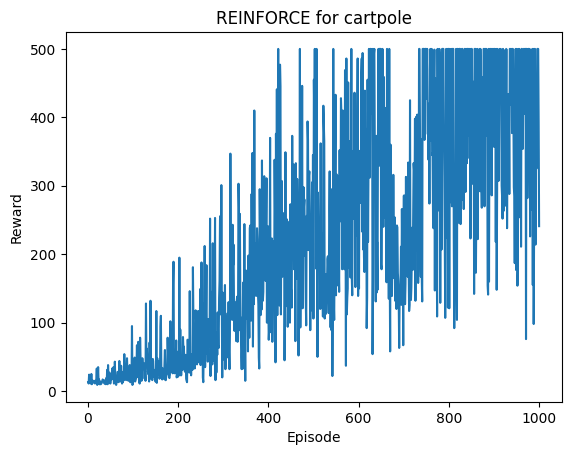

In [257]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE for cartpole")

# Display the plot
plt.show()

In [149]:
env = gym.make("Acrobot-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim)
optimizer = optim.Adam(policy.parameters(), lr=3e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rw, logp, _ = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    R = discounted_rewards(rw, discount_factor)
    R = torch.as_tensor(R, dtype=torch.float32, device=device)
    R = (R - R.mean()) / (R.std() + 1e-8)
    logp = torch.stack(logp)
    loss = -(logp * R).sum()
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

        

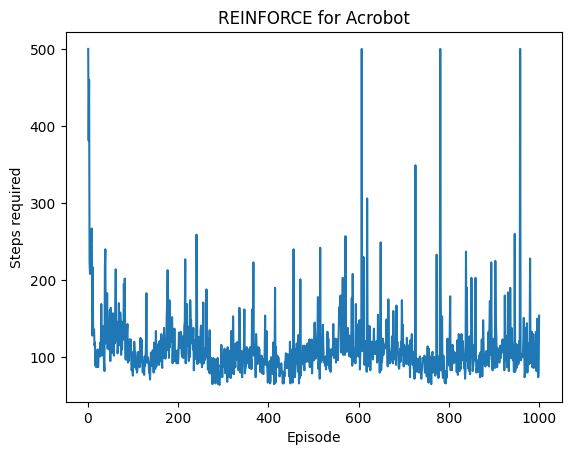

In [150]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Steps required")
plt.title("REINFORCE for Acrobot")

# Display the plot
plt.show()


# REINFORCE with baseline

In [235]:
from torch.distributions import Categorical, Normal, MultivariateNormal

class ReinforceWithBaseline(nn.Module):
    def __init__(self, p_dim=2, state_dim=4, hidden_dim=128):
        super().__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, p_dim)
        
    def forward(self, x):
        return self.linear2(self.linear1(x))

    def sample_action(self, probs):
        # probs = torch.tensor(p)
        categorical_dist = Categorical(probs)
        sample = categorical_dist.sample()
        
        return sample

class StateValue(nn.Module):
    def __init__(self, state_dim=4, hidden_dim=32):
        super().__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        return self.linear2(self.linear1(x))


def state_values(state_param, states_seen):
    st_vals = torch.zeros((len(states_seen)))
    for i, st in enumerate(states_seen):
        cur_val = state_param(st)
        st_vals[i] = cur_val
    return st_vals

In [258]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
policy = Reinforce(act_dim, obs_dim)
sv = StateValue(state_dim=obs_dim)
optimizer = optim.Adam(policy.parameters(), lr=3e-4)
optimizer_sv = optim.Adam(sv.parameters(), lr=5e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
episodes = 1000
discount_factor = 0.99
total_reward = []
for ep in range(episodes):
    rw, logp, st = gen_episode(env, policy, device)
    total_reward.append(len(rw))
    R = discounted_rewards(rw, discount_factor)
    R = torch.as_tensor(R, dtype=torch.float32, device=device)
    st = torch.as_tensor(st, dtype=torch.float32, device=device)
    # R = (R - R.mean()) / (R.std() + 1e-8)
    state_value_approx = state_values(sv, st)
    # state_value_approx = torch.as_tensor(state_value_approx, dtype=torch.float32, device=device)
    delta = R - state_value_approx
    delta = delta.detach()
    # print(state_value_approx.requires_grad, delta.requires_grad)
    # break
    logp = torch.stack(logp)
    loss = -(logp * delta).sum()
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    # State-value function approximater update
    # state_value_approx = torch.stack(state_value_approx)
    loss_sv = -(delta * state_value_approx).sum()
    optimizer_sv.zero_grad()
    loss_sv.backward()
    # nn.utils.clip_grad_norm_(sv.parameters(), 1.0)
    optimizer_sv.step()


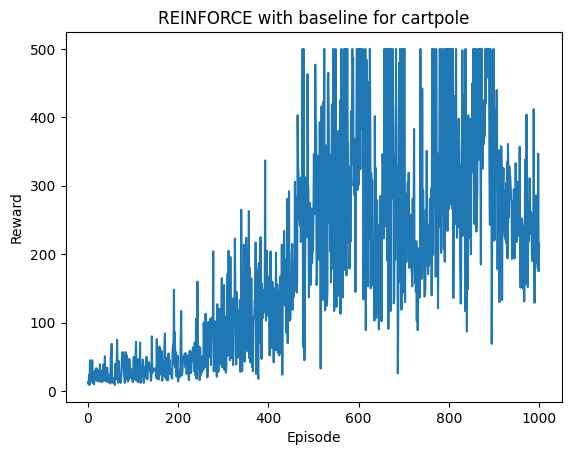

In [259]:
plt.plot(np.linspace(1, len(total_reward), len(total_reward)), total_reward)

# Add labels and title
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("REINFORCE with baseline for cartpole")

# Display the plot
plt.show()